In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D

In [2]:
np.random.seed(11)
tf.random.set_seed(11)
batch_size = 128
max_epochs = 50
filters = [32,32,16]


In [3]:
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

x_train = np.reshape(x_train, (len(x_train),28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise = 0.5
x_train_noisy = x_train + noise * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

x_train_noisy = x_train_noisy.astype('float32')
x_test_noisy = x_test_noisy.astype('float32')

#print(x_test_noisy[1].dtype)


11493376/11490434 [==============================] - 0s 0us/step


In [4]:

class Encoder(K.layers.Layer):
    def __init__(self, filters):
        super(Encoder, self).__init__()
        self.conv1 = Conv2D(filters=filters[0], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv2 = Conv2D(filters=filters[1], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv3 = Conv2D(filters=filters[2], kernel_size=3, strides=1, activation='relu', padding='same')
        self.pool = MaxPooling2D((2, 2), padding='same')
               
    
    def call(self, input_features):
        x = self.conv1(input_features)
        #print("Ex1", x.shape)
        x = self.pool(x)
        #print("Ex2", x.shape)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        return x

In [5]:

class Decoder(K.layers.Layer):
    def __init__(self, filters):
        super(Decoder, self).__init__()
        self.conv1 = Conv2D(filters=filters[2], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv2 = Conv2D(filters=filters[1], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv3 = Conv2D(filters=filters[0], kernel_size=3, strides=1, activation='relu', padding='valid')
        self.conv4 = Conv2D(1, 3, 1, activation='sigmoid', padding='same')
        self.upsample = UpSampling2D((2, 2))
  
    def call(self, encoded):
        x = self.conv1(encoded)
        #print("dx1", x.shape)
        x = self.upsample(x)
        #print("dx2", x.shape)
        x = self.conv2(x)
        x = self.upsample(x)
        x = self.conv3(x)
        x = self.upsample(x)
        return self.conv4(x)

In [6]:
class Autoencoder(K.Model):
    def __init__(self, filters):
        super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(filters)
        self.decoder = Decoder(filters)

    def call(self, input_features):
        #print(input_features.shape)
        encoded = self.encoder(input_features)
        #print(encoded.shape)
        reconstructed = self.decoder(encoded)
        #print(reconstructed.shape)
        return reconstructed

In [7]:
model = Autoencoder(filters)

model.compile(loss='binary_crossentropy', optimizer='adam')

loss = model.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=max_epochs,
                batch_size=batch_size)

Epoch 1/50
469/469 [==============================] - 21s 31ms/step - loss: 0.2049 - val_loss: 0.1507
Epoch 2/50
469/469 [==============================] - 14s 30ms/step - loss: 0.1415 - val_loss: 0.1321
Epoch 3/50
469/469 [==============================] - 14s 30ms/step - loss: 0.1287 - val_loss: 0.1238
Epoch 4/50
469/469 [==============================] - 14s 30ms/step - loss: 0.1223 - val_loss: 0.1191
Epoch 5/50
469/469 [==============================] - 14s 30ms/step - loss: 0.1181 - val_loss: 0.1152
Epoch 6/50
469/469 [==============================] - 14s 30ms/step - loss: 0.1150 - val_loss: 0.1126
Epoch 7/50
469/469 [==============================] - 13s 29ms/step - loss: 0.1126 - val_loss: 0.1105
Epoch 8/50
469/469 [==============================] - 15s 31ms/step - loss: 0.1109 - val_loss: 0.1092
Epoch 9/50
469/469 [==============================] - 14s 31ms/step - loss: 0.1094 - val_loss: 0.1081
Epoch 10/50
469/469 [==============================] - 14s 29ms/step - loss: 0.108

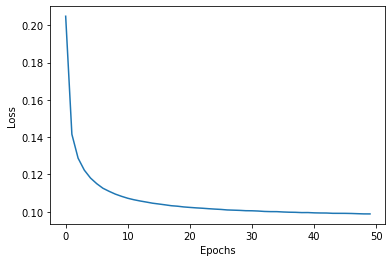

In [8]:

plt.plot(range(max_epochs), loss.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

ResourceExhaustedError: OOM when allocating tensor with shape[10000,32,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

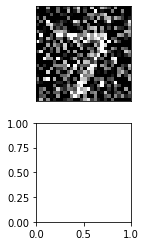

In [9]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test_noisy[index].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(tf.reshape(model(x_test_noisy)[index], (28, 28)), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()